## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path) 

In [3]:
data = pd.read_csv("Cleaned data\data.csv")

In [4]:
# drop columns
df = data.drop(columns=[
    "DATE","FORECASTDEMAND","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


In [5]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# create response and lookback variables
cols_to_shift = ["HUMIDITY","WINDSPEED","TOTALDEMAND","HOLIDAY","SOLAR","RRP","OUTPUT","TEMPAVE"]
col_y = ["TOTALDEMAND"]
lookback = 2
cols = list()
cols.append(df)
# create lookback lag variables
for i in range(lookback, 0, -1):
    cols.append(df[cols_to_shift].shift(i).add_suffix(f' (t-{i})'))
# create response variable, 1 day lookahead
cols.append(df[col_y].shift(-1).add_suffix(f' (t+1)').rename(columns={"TOTALDEMAND (t+1)": "y"}))
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
print(len(agg))
agg.head()

2373


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN,HUMIDITY (t-2),WINDSPEED (t-2),TOTALDEMAND (t-2),HOLIDAY (t-2),SOLAR (t-2),RRP (t-2),OUTPUT (t-2),TEMPAVE (t-2),HUMIDITY (t-1),WINDSPEED (t-1),TOTALDEMAND (t-1),HOLIDAY (t-1),SOLAR (t-1),RRP (t-1),OUTPUT (t-1),TEMPAVE (t-1),y
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,7367.750278
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,7462.242014
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,7446.890903
5,2016,1,6,0.826364,31.590909,7446.890903,0.0,3.1,36.020417,23.465,18.35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,7325.488438
6,2016,1,7,0.904884,32.418605,7325.488438,0.0,19.6,36.541667,23.465,20.60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.826364,31.590909,7446.890903,0.0,3.1,36.020417,23.465,18.35,7413.678576


In [169]:
test_len = len(agg.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))])
train = agg.iloc[:-test_len,:]
test = agg.iloc[-test_len:, :]
X_train = train.drop(["y"],axis=1)
y_train = train[["y"]]
X_test = test.drop(["y"],axis=1)
y_test = test[["y"]]

In [178]:
n_splits = int(len(train) // (365/2))
start = 0
end = round(len(train)/n_splits)
sub_test_len = 20
X_trains = pd.DataFrame([])
X_tests = pd.DataFrame([])
y_tests = []
y_preds = []
split = 1
scaler = MinMaxScaler()
while end < (len(train)+100): #includes a buffer
    print(split)
    sub_y_train = y_train.iloc[start:end-sub_test_len,:]
    sub_y_test = y_test.iloc[end-sub_test_len:end,:]
    sub_X_train = X_train.iloc[start:end-sub_test_len,:]
    sub_X_test = X_test.iloc[end-sub_test_len:end,:]
    # print(start, end, sub_X_test)
    sub_X_train_scaled = pd.DataFrame(scaler.fit_transform(sub_X_train))
    sub_X_test_scaled = pd.DataFrame(scaler.fit_transform(sub_X_test))
    # model fit
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(sub_X_train_scaled, sub_y_train)
    # forecast
    y_pred = model.predict(sub_X_test_scaled)
    # store
    y_preds += list(y_pred)
    y_tests += list(sub_y_test["y"])
    X_tests = X_tests.append(sub_X_test_scaled)
    X_trains = X_trains.append(sub_X_train_scaled)
    start += round(end/2)
    end += round(end/2)
    split += 1 


1
2
3


ValueError: Found array with 0 sample(s) (shape=(0, 34)) while a minimum of 1 is required by MinMaxScaler.

In [153]:
error = mean_absolute_error(y_tests, y_preds)
error

383.0841081818402

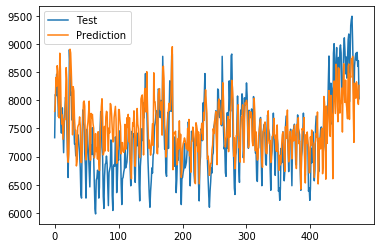

In [156]:
# plot expected vs preducted
plt.plot(y_tests, label='Test')
plt.plot(y_preds, label='Prediction')
plt.legend() 
plt.show() 